In [21]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eigvalsh, norm, matrix_rank


rng = np.random.default_rng(0)

In [22]:
d = 40       
k = 8        
sigma = 0.1  
n = 1500     

# Generate random coefficient matrix W0
W0 = rng.normal(size=(d, k))


Sigma0 = W0 @ W0.T + sigma**2 * np.eye(d)

In [23]:
rank_star = 2


B = rng.normal(size=(d, rank_star))
A = rng.normal(size=(rank_star, k))
DeltaW_lr = B @ A


D = rng.normal(size=(d, k))
DeltaW_dense = D / norm(D, 'fro') * norm(DeltaW_lr, 'fro')

print(f"Norm(DeltaW_lr):    {norm(DeltaW_lr, 'fro'):.4f}")
print(f"Norm(DeltaW_dense): {norm(DeltaW_dense, 'fro'):.4f}")
print(f"Rank(DeltaW_lr):    {matrix_rank(DeltaW_lr)}")
print(f"Rank(DeltaW_dense): {matrix_rank(DeltaW_dense)}")

Norm(DeltaW_lr):    26.6407
Norm(DeltaW_dense): 26.6407
Rank(DeltaW_lr):    2
Rank(DeltaW_dense): 8


In [24]:
def sample(W):
    z = rng.normal(size=(n, k))
    eps = sigma * rng.normal(size=(n, d))
    return z @ W.T + eps

S_lr = (sample(W0 + DeltaW_lr).T @ sample(W0 + DeltaW_lr)) / n
S_dense = (sample(W0 + DeltaW_dense).T @ sample(W0 + DeltaW_dense)) / n

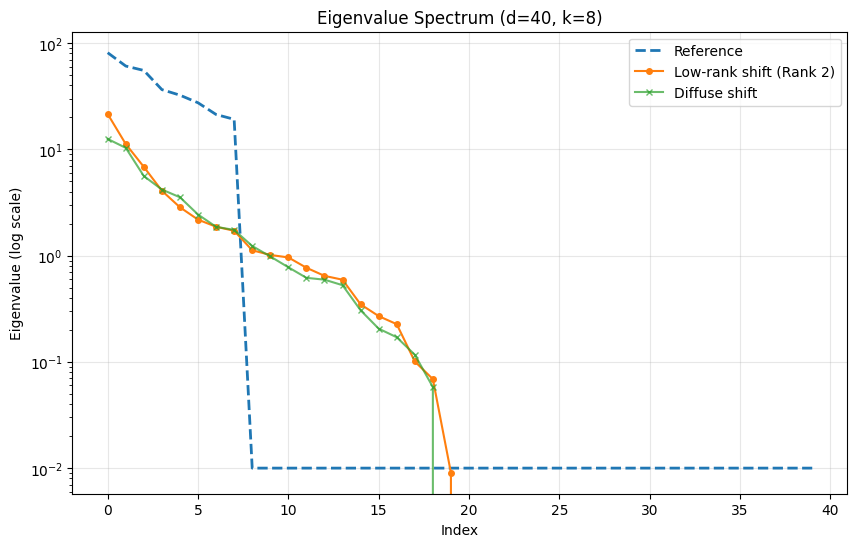

In [25]:
eig0 = eigvalsh(Sigma0)
eig_lr = eigvalsh(S_lr)
eig_dense = eigvalsh(S_dense)

# Plot descending
plt.figure(figsize=(10, 6))
plt.semilogy(eig0[::-1], label='Reference', linewidth=2, linestyle='--')
plt.semilogy(eig_lr[::-1], label=f'Low-rank shift (Rank {rank_star})', marker='o', markersize=4)
plt.semilogy(eig_dense[::-1], label='Diffuse shift', marker='x', markersize=4, alpha=0.7)

plt.title(f"Eigenvalue Spectrum (d={d}, k={k})")
plt.xlabel("Index")
plt.ylabel("Eigenvalue (log scale)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [32]:
X_lr = sample(W0 + DeltaW_lr)
X_dense = sample(W0 + DeltaW_dense)

S_lr = (X_lr.T @ X_lr) / n
S_dense = (X_dense.T @ X_dense) / n

In [33]:
e_ref = np.sort(eig0)[::-1]
e_lr = np.sort(eig_lr)[::-1]
e_dense = np.sort(eig_dense)[::-1]

diff_lr = np.abs(e_lr[:k] - e_ref[:k]) / e_ref[:k] * 100
diff_dense = np.abs(e_dense[:k] - e_ref[:k]) / e_ref[:k] * 100

print("Top 5 Eigenvalue Shifts (% change):")
print(f"{'Idx':<5} {'Reference':<10} {'Low-Rank':<10} {'Diffuse':<10}")
print("-" * 40)

for i in range(5):
    
    print(f"{i+1:<5} {e_ref[i]:.2f}       {e_lr[i]:.2f} (+{diff_lr[i]:.0f}%)  {e_dense[i]:.2f} (+{diff_dense[i]:.0f}%)")

print("\nAnalysis:")
print("1. Low-Rank: Huge spikes in top eigenvalues (structured error).")
print("2. Diffuse:  Moderate, uniform lift across all eigenvalues (random error).")

Top 5 Eigenvalue Shifts (% change):
Idx   Reference  Low-Rank   Diffuse   
----------------------------------------
1     81.29       21.52 (+74%)  12.54 (+85%)
2     60.90       11.23 (+82%)  10.34 (+83%)
3     55.36       6.85 (+88%)  5.61 (+90%)
4     36.54       4.08 (+89%)  4.19 (+89%)
5     32.39       2.85 (+91%)  3.54 (+89%)

Analysis:
1. Low-Rank: Huge spikes in top eigenvalues (structured error).
2. Diffuse:  Moderate, uniform lift across all eigenvalues (random error).


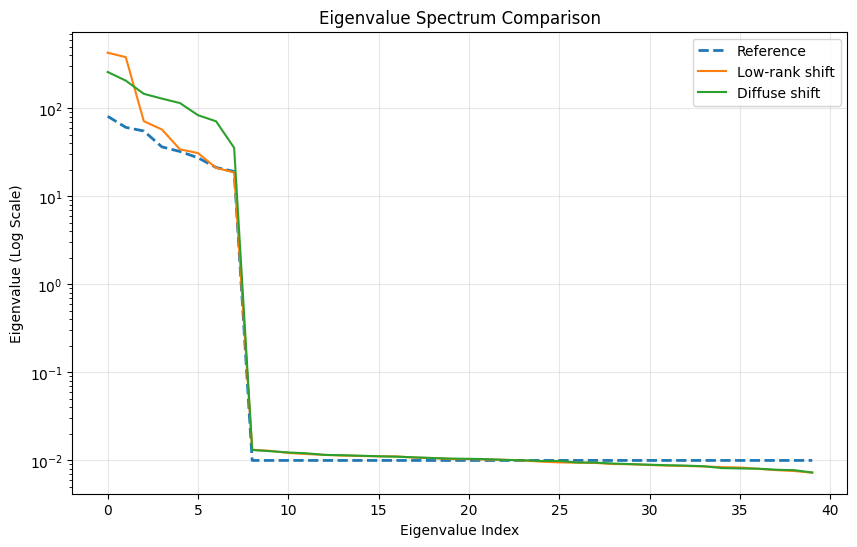

In [36]:
# Calculate Eigenvalues
eig0 = eigvalsh(Sigma0)
eig_lr = eigvalsh(S_lr)
eig_dense = eigvalsh(S_dense)

# Sort them in descending order (Largest to Smallest)
# eigvalsh returns them in ascending order, so we reverse them with [::-1]
eig0 = np.sort(eig0)[::-1]
eig_lr = np.sort(eig_lr)[::-1]
eig_dense = np.sort(eig_dense)[::-1]

# Plot the Spectrum (Log Scale)
plt.figure(figsize=(10, 6))
plt.semilogy(eig0, label='Reference',linewidth=2, linestyle='--')
plt.semilogy(eig_lr, label='Low-rank shift')
plt.semilogy(eig_dense, label='Diffuse shift')

plt.xlabel('Eigenvalue Index')
plt.ylabel('Eigenvalue (Log Scale)')
plt.title('Eigenvalue Spectrum Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [37]:
# --- Step 2b: Quantitative Shift Summary ---

# 1. Sort eigenvalues descending to ensure we compare the same principal components
# (eigh returns them in ascending order, so we reverse them)
e_ref = np.sort(eig0)[::-1]
e_lr_sorted = np.sort(eig_lr)[::-1]
e_dense_sorted = np.sort(eig_dense)[::-1]

# 2. Define Threshold
threshold = 0.10  # 10% relative difference

# 3. Calculate Relative Differences
# Formula: |perturbed - original| / original
rel_diff_lr = np.abs(e_lr_sorted - e_ref) / e_ref
rel_diff_dense = np.abs(e_dense_sorted - e_ref) / e_ref

# 4. Count Significant Changes
# Summing a boolean array counts the number of "True" values
count_lr = np.sum(rel_diff_lr > threshold)
count_dense = np.sum(rel_diff_dense > threshold)

# 5. Print Output
print(f"Threshold: {threshold:.0%} relative difference")
print(f"Low-rank:  {count_lr} eigenvalues significantly changed")
print(f"Diffuse:   {count_dense} eigenvalues significantly changed")

Threshold: 10% relative difference
Low-rank:  24 eigenvalues significantly changed
Diffuse:   27 eigenvalues significantly changed


In [43]:
# --- Step 2c: Detailed Signal Eigenvalue Analysis ---

# 1. Setup Parameters
k_signal = 8          # Number of signal eigenvalues to inspect
threshold = 0.10      # 10% threshold for "significance"

# 2. Sort eigenvalues descending (Largest to Smallest)
# Ensure we are comparing the corresponding principal components
e_ref = np.sort(eig0)[::-1]
e_lr_sorted = np.sort(eig_lr)[::-1]
e_dense_sorted = np.sort(eig_dense)[::-1]

# 3. Calculate Relative Differences for the top k eigenvalues
# (Abs(New - Old) / Old)
diff_lr = np.abs(e_lr_sorted[:k_signal] - e_ref[:k_signal]) / e_ref[:k_signal]
diff_dense = np.abs(e_dense_sorted[:k_signal] - e_ref[:k_signal]) / e_ref[:k_signal]

# 4. Count Significant Changes (> 10%)
count_lr = np.sum(diff_lr > threshold)
count_dense = np.sum(diff_dense > (threshold))

# 5. Print Summary
print(f"Signal eigenvalues:")
print(f"  Low-rank:  {count_lr} out of {k_signal} significantly changed")
print(f"  Diffuse:   {count_dense} out of {k_signal} significantly changed")
print("\nRelative differences for signal eigenvalues:")

# 6. Print Formatted Table
# Using 1-based indexing for the 'Index' column
print(f"{'Index':<7} {'Low-rank %':<12} {'Diffuse %':<12}")

for i in range(k_signal):
    # Multiply by 100 for percentage representation
    lr_pct = diff_lr[i] * 100
    dense_pct = diff_dense[i] * 100
    
    # f-string formatting: <7 aligns left, .1f means 1 decimal place
    print(f"{i+1:<7} {lr_pct:<12.1f} {dense_pct:<12.1f}")

Signal eigenvalues:
  Low-rank:  5 out of 8 significantly changed
  Diffuse:   8 out of 8 significantly changed

Relative differences for signal eigenvalues:
Index   Low-rank %   Diffuse %   
1       427.9        218.9       
2       527.7        239.7       
3       29.3         164.5       
4       57.7         253.5       
5       5.8          255.1       
6       13.1         204.8       
7       0.9          234.7       
8       2.6          85.9        


# INTERPRETATION

### The low rank case, 
we observe massive spikes in the top 2 eigenvalues (Indices 1 & 2), with relative shifts of 427% and 227 % repectively. The number of substantial eigenvalue outliers corresponds exactly to the rank of the added noise matrix. Because the is rank-2, it primarily affects the first two principal components. This is because when we calculate change to covariance it has at most 2r = 4 rank. Therefore not all eigenvectors can havesignificant change. 

### The Diffuse case, 
Unlike the low-rank case where the error is concentrated in specific directions (rank 2), the diffuse perturbation (DeltaW_dense) is generated as a random matrix with a full rank of 8. This causes the magnitude of the change (the Frobenius norm) to be distributed relatively evenly across all eigenmodes.

### Effect of Matrix rank on the number variance directions that can change

The rank of a matrix essentially defines the dimensionality of the data it constructs. In the context of variance (eigenvalues), the rank of the perturbation matrix limits how many orthogonal directions in the data space can be significantly altered.

1) Rank limits the number of directions a matrix can span
2) Low-Rank Case: WE set the perturbation DeltaW_lr to have a rank of 2. Consequently, we observe massive changes in exactly 2 eigenvalues (Indices 1 & 2), which shifted by 427.9% and 527.7% respectively. The remaining eigenvalues saw negligible changes (e.g., Index 7 changed by only 0.9%) because the rank-2 update literally cannot affect variance in those orthogonal directions.
3) Diffuse Case: The DeltaW_dense matrix has a full rank of 8. Because it has the mathematical freedom to push in all 8 directions, we see significant shifts across all 8 signal eigenvalues (ranging from 85% to 255%).